In [40]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.optimizers import Adam

In [41]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [42]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [43]:
df['label'] = df['filename'].str.split('_').str[-2]

In [44]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

In [45]:
def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2


In [46]:
def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

In [47]:
columns_to_drop = ['label','filename']

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [61]:
num_neurons = 128
input_shape = X_train.shape[1]

model = Sequential([
    InputLayer(input_shape=(input_shape,)),
    Dense(num_neurons, activation='relu'),
    Dropout(0.2),
    Dense(num_neurons, activation='relu'),
    Dropout(0.2),
    Dense(num_neurons, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               9984      
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                

In [63]:
def early_stopping(monitor='val_loss', patience=3):
    return [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)]

In [64]:
num_epochs = 100
batch_size = 256

history = model.fit(X_train, y_train, 
                epochs=num_epochs, 
                batch_size=batch_size, 
                verbose = 2,
                callbacks=early_stopping('loss', 3),
                validation_data=(X_test, y_test)
            )

Epoch 1/100
499/499 - 17s - loss: 715.7327 - accuracy: 0.5054 - val_loss: 0.6934 - val_accuracy: 0.5077 - 17s/epoch - 34ms/step
Epoch 2/100
499/499 - 12s - loss: 1.9958 - accuracy: 0.5098 - val_loss: 0.6930 - val_accuracy: 0.5077 - 12s/epoch - 25ms/step
Epoch 3/100
499/499 - 14s - loss: 1.2226 - accuracy: 0.5098 - val_loss: 0.6930 - val_accuracy: 0.5077 - 14s/epoch - 28ms/step
Epoch 4/100
499/499 - 12s - loss: 1.0018 - accuracy: 0.5100 - val_loss: 0.6930 - val_accuracy: 0.5077 - 12s/epoch - 24ms/step
Epoch 5/100
499/499 - 12s - loss: 0.8694 - accuracy: 0.5100 - val_loss: 0.6930 - val_accuracy: 0.5077 - 12s/epoch - 25ms/step
Epoch 6/100
499/499 - 12s - loss: 0.7963 - accuracy: 0.5100 - val_loss: 0.6930 - val_accuracy: 0.5077 - 12s/epoch - 23ms/step
Epoch 7/100
499/499 - 10s - loss: 0.7709 - accuracy: 0.5100 - val_loss: 0.6931 - val_accuracy: 0.5077 - 10s/epoch - 21ms/step
Epoch 8/100
499/499 - 11s - loss: 0.7671 - accuracy: 0.5099 - val_loss: 0.6930 - val_accuracy: 0.5077 - 11s/epoch - 

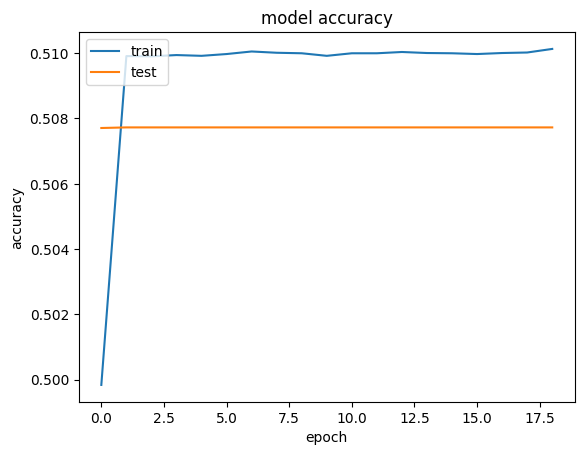

In [59]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

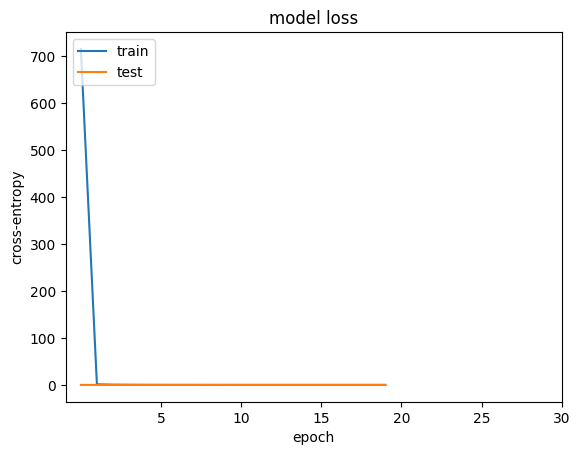

In [65]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30])
plt.legend(['train', 'test'], loc='upper left')